# Clasificación de Imágenes Dermatológicas con EfficientNetB0

## 1. IMPORTACIÓN DE LIBRERÍAS
Importamos las librerías necesarias para el procesamiento de datos, construcción y entrenamiento del modelo.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


## 2. Configuración de parámetros y recursos
Configuramos los parámetros principales y verificamos la disponibilidad de GPU para acelerar el entrenamiento.

In [ ]:
mixed_precision.set_global_policy('float32')

# Parámetros
img_size = (224, 224)
batch_size = 32
epochs = 100
seed = 123
train_dir = '../dataset/multi-6/train'
test_dir = '../dataset/multi-6/test'
model_path = 'efficientnetb0_derma_v4.keras'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)
# Obtener número de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("Clases:", class_names)

#Imprimir dataset
for x, y in train_ds.take(5):
    print("Imagen shape:", x.shape)
    print("Etiqueta:", y.numpy())


Found 30900 files belonging to 6 classes.
Using 24720 files for training.
Found 30900 files belonging to 6 classes.
Using 6180 files for validation.
Clases: ['Acne', 'Benign', 'Eczema', 'Infectious', 'Malign', 'Pigmentation']
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 3 1 1 3 0 4 2 2 1 3 1 1 5 1 3 4 1 1 1 3 1 1 1 1 2 1 2 3 1 0]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [0 1 5 1 1 1 4 3 1 0 3 1 4 1 3 4 4 1 2 1 5 4 4 4 3 1 2 0 4 1 1 4]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 0 0 4 1 3 1 4 1 3 3 4 5 4 3 4 2 4 1 4 3 4 4 1 4 4 1 3 3 3 1 1]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [1 3 1 1 1 1 1 1 4 0 3 4 1 2 3 1 1 5 2 1 4 2 3 3 4 4 2 2 1 1 1 2]
Imagen shape: (32, 224, 224, 3)
Etiqueta: [2 4 1 1 2 3 3 3 4 3 1 0 1 1 3 5 3 5 2 4 2 1 3 1 1 0 0 4 3 4 1 0]


## 8. Evaluación y visualización de resultados
Evaluamos el modelo en el conjunto de test, mostramos el reporte de clasificación y la matriz de confusión.

194/194 [==============================] - 157s 774ms/step

🧾 Clasification Report:

              precision    recall  f1-score   support

        Acne       0.08      0.08      0.08       397
      Benign       0.36      0.24      0.29      2162
      Eczema       0.16      0.17      0.17       831
  Infectious       0.19      0.22      0.21      1238
      Malign       0.21      0.30      0.25      1338
Pigmentation       0.01      0.01      0.01       214

    accuracy                           0.22      6180
   macro avg       0.17      0.17      0.17      6180
weighted avg       0.24      0.22      0.22      6180



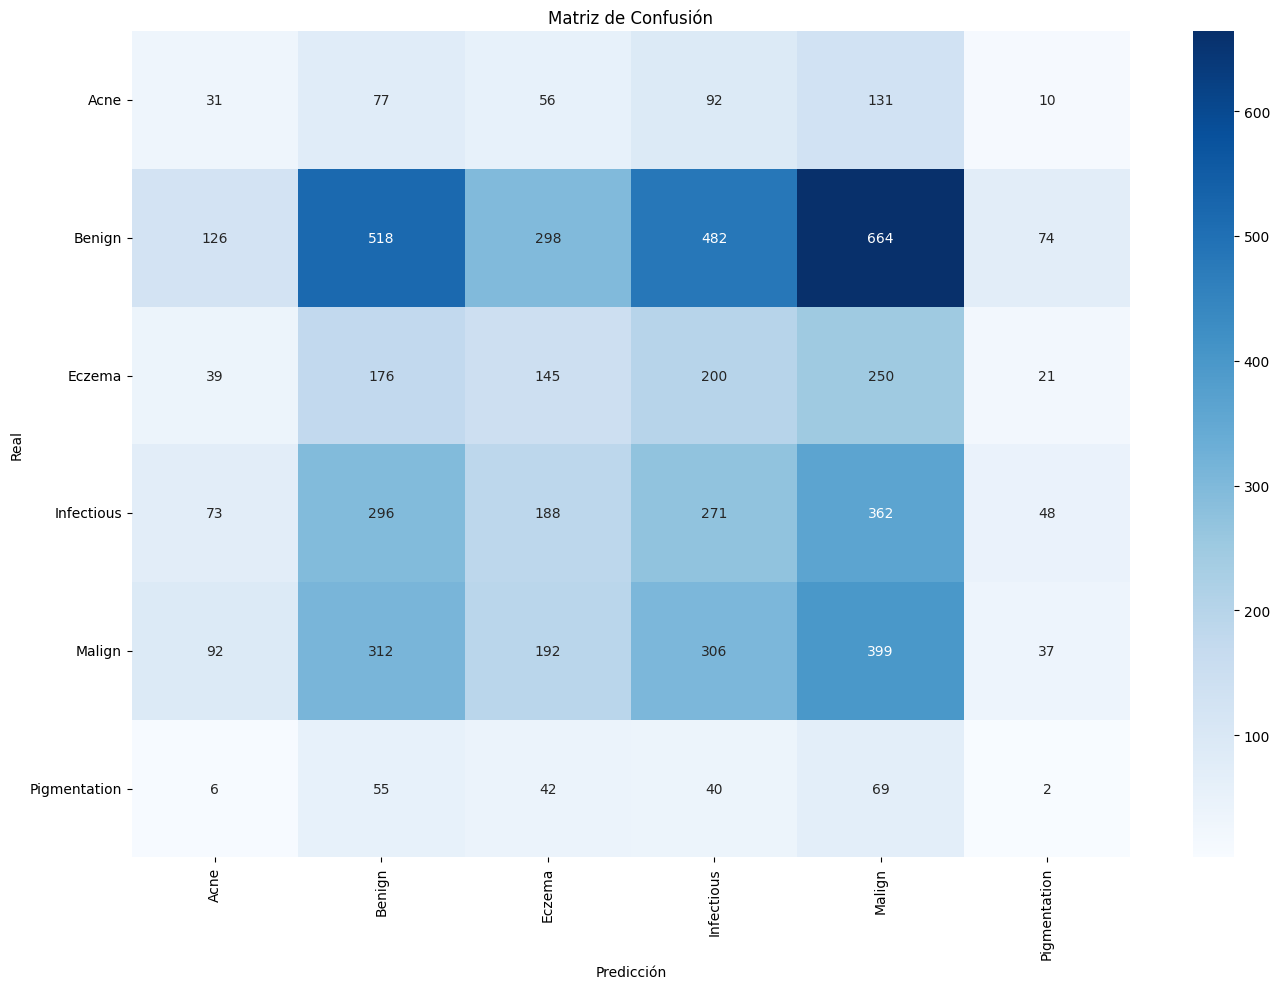

In [ ]:

# Cargar modelo entrenado
model = tf.keras.models.load_model(model_path)

num_classes = len(class_names)

y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y.numpy() for x, y in val_ds])

print("\n🧾 Clasification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Las 3 clases más probables

In [ ]:
from IPython.display import display, HTML

# Definir el nivel de gravedad de cada clase
gravedad = {
    0: 0,  # Acne
    1: 0,  # Benign
    2: 1,  # Eczema
    3: 1,  # Infectious
    4: 2,  # Malign
    5: 0   # Pigmentation
}

top_k = 4  # Considerar las 4 clases más probables
num_imgs = 50  # Primeras 10 imágenes

y_true = np.concatenate([y.numpy() for x, y in val_ds])

for i in range(num_imgs):
    probs = y_pred_probs[i]
    real_idx = y_true[i]
    top_indices = np.argsort(probs)[-top_k:][::-1]
    idx1 = top_indices[0]
    conf1 = probs[idx1]
    pred_idx = idx1
    motivo = ""
    diferencia_elegida = 0.0
    
    # Buscar entre las top_k si hay alguna más grave y cercana en confianza
    for idx in top_indices[1:]:
        conf = probs[idx]
        diff = conf1 - conf
        if (diff < 0.10) and (gravedad[idx] > gravedad[pred_idx]):
            pred_idx = idx
            motivo = f"<span style='color:orange'>*Se elige {class_names[idx]} por mayor gravedad y confianza cercana*</span>"
            diferencia_elegida = diff

    color = "green" if pred_idx == real_idx else "red"

    html = f"<b>Imagen {i+1}:</b><br>"
    for j, idx in enumerate(top_indices):
        diff = conf1 - probs[idx]
        if j == 0:
            html += f"{j+1}ª: {class_names[idx]}: {probs[idx]*100:.2f}%<br>"
        else:
            html += f"{j+1}ª: {class_names[idx]}: {probs[idx]*100:.2f}% (diferencia: {diff*100:.2f}%)<br>"
    if motivo:
        html += motivo + f" (diferencia: {diferencia_elegida*100:.2f}%)<br>"
    html += f"<b>Predicción final:</b> <span style='color:{color}'>{class_names[pred_idx]}</span><br>"
    html += f"<b>Real:</b> {class_names[real_idx]}"
    html += "<hr>"
    display(HTML(html))